# READ ME

#### This notebook is implemeted in a repository in github with input and output folders.
#### It has 2 parts:
##### > Part 1: Pre-defined funtions for each technique.
##### > Part 2: Execution of model pipelines, here users can modify which combination of techniques they want to run. The scores will be printed as a csv in output folders. 

# PART 1: FUNCTIONS

# Import library

In [191]:
#importing libraries
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from boruta import BorutaPy
from BorutaShap import BorutaShap
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

from collections import Counter
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, log_loss, cohen_kappa_score

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Read df

In [16]:
#this function is to read, transform and join 2 data frame

def read_features():
    path = '../secom.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['feature_'+str(x+1) for x in range(len(df.columns))]
    return df


def read_target():
    path = '../secom_labels.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['status','timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'],dayfirst=True)
    return df


# Remove duplicated columns

In [3]:
#find the duplicated features (columns)
def remove_duplicated_columns(df):
    list_duplicate = []
    to_remove = []
    for i in range(0, len(df.columns)):
        l = []
        for j in range(i+1,len(df.columns)):
            if df.iloc[:,i].equals(df.iloc[:,j]) == True:
                if j not in list_duplicate:
                    l.append(j)
                    to_remove.append('feature_'+str(j+1))
                list_duplicate.append(i)
                list_duplicate.append(j)

    return df.drop(columns=to_remove, axis = 1)

# X = remove_duplicated_columns(X)
# X.shape


# Remove columns with Constant volatility (std=0)

In [4]:
def remove_constant_volatility(df):
    df_EDA= df.describe().T
    df_EDA= df_EDA[df_EDA["std"] == 0]
    df = df.drop(axis=1, columns=df_EDA.index)
    return df

# X = remove_constant_volatility(X)
# X.shape

# Remove columns with high %Missing values

In [5]:
def remove_cols_with_high_pct_null(df, null_threshold):
    list_column_with_pct_null = pd.concat([df.isnull().sum(), df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    list_column_with_pct_null= list_column_with_pct_null[list_column_with_pct_null["Percentage (%)"] >= null_threshold]
    df = df.drop(axis=1, columns=list_column_with_pct_null.index)
    return df

# X = remove_cols_with_high_pct_null(X, 0.8)
# X.shape

# Split data

In [7]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1,stratify=y)

# Outlier treatment

In [6]:
#how = ['NaN', '3s' ,'nothing']
def replace_outlier(df, how):
    for col in df:
        ll_col = df[col].mean() - 3 * df[col].std()
        ul_col = df[col].mean() + 3 * df[col].std()
        if how == 'NaN':
            df[col] = np.where(df[col]>ul_col,np.NaN,np.where(df[col]<ll_col,np.NaN,df[col]))
        elif how == '3s':
            df[col] = np.where(df[col]>ul_col,ul_col,np.where(df[col]<ll_col,ll_col,df[col]))
    return df

# Missing value Imputation

In [7]:
#which_weights = ['distance','uniform']

def impute_null_with_knn(X_train, X_test, which_weights):
    #First scale the data 
    scaler = MinMaxScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns= X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns= X_test.columns)

    knn = KNNImputer(n_neighbors=5, weights=which_weights) #check this neighbors = 5

    X_train = pd.DataFrame(knn.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(knn.transform(X_test), columns=X_test.columns)
    
    X_train = pd.DataFrame(scaler.inverse_transform(X_train), columns= X_train.columns)
    X_test = pd.DataFrame(scaler.inverse_transform(X_test), columns= X_test.columns)
    return X_train, X_test

#X_train = impute_null_with_knn(X_train)

In [8]:
def impute_null_with_mice(X_train, X_test): 
    imp = IterativeImputer(max_iter=5, verbose=0, imputation_order='roman', random_state=0)
    X_train = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(imp.transform(X_test), columns=X_test.columns)
    return X_train, X_test

# Feature Selection

In [9]:
#This is BorutaShap with TENTATIVE features

#list_method=['shap','gini']

def BorutaShap_FS (X, y,method_option) :
    #modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, class_weight='balanced_subsample', max_depth=5, random_state=100)
    modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)

    # define model for resp. classifier
    modelshap.fit(X,y)
    feature_names = np.array(X.columns)
    # define Boruta Sahp feature selection method
    feature_selector = BorutaShap(model=modelshap,
                              importance_measure=method_option,
                              classification=True)  # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = False,random_state=100)  
    #feature_selector.plot(which_features='accepted',figsize=(20,10))
    tentative=X.loc[:,feature_selector.tentative]
    selected=feature_selector.Subset()
    selten=pd.concat([selected,tentative],axis=1)
    # call transform() on X to filter it down to selected features
    return  selten

In [10]:
#RFE

#classifier = ['RF', 'SVM']

def RFE_FS (X, y,classify) :
    scaler = MinMaxScaler()
    X_scaled= pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    feature_names = np.array(X_scaled.columns)
    if classify == 'RF':
    # define random forest classifier
        model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
       
    if classify== 'SVM':
        model = SVC(kernel='linear',C=5)
        #rfe = RFECV(estimator = model,scoring='accuracy')
    # find all relevant features
    model.fit(X_scaled, y)
    rfe = RFE(estimator = model,n_features_to_select = 30)
    rfe.fit(X_scaled,y)

     # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             rfe.ranking_, 
                             rfe.support_))

    final_features_rfe = list()
    indexes = np.where(rfe.ranking_ <= 2)
    for x in np.nditer(indexes):
        final_features_rfe.append(feature_names[x])
    
    
    # unscale the data before return
    X_unscaled=pd.DataFrame(scaler.inverse_transform(X_scaled), columns=X_scaled.columns)
    ff_rfe=pd.DataFrame(X_unscaled.filter(final_features_rfe))
    

 # call transform() on X to filter it down to selected features
    return  ff_rfe

In [11]:
#Boruta function with random forest

def BorutaPy_FS (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
    model.fit(X, y)
    # define Boruta feature selection method
    
    feature_selector = BorutaPy(model, n_estimators='auto', verbose=0, random_state=100, max_iter=140)

    # find all relevant features
    feature_selector.fit(X.to_numpy(),y)

    # check selected features
    ##--feature_selector.support_

    # check ranking of features
    ##--feature_ranking=feature_selector.ranking_

    # zip feature names, ranks, and decisions 
    # feature_ranks = list(zip(feature_names, 
    #                          feature_selector.ranking_, 
    #                          feature_selector.support_))

    # print the results
    ##--for feat in feature_ranks:
    ##--    print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features = list()
    indexes = np.where(feature_selector.ranking_ <= 2) #change to 2
    for x in np.nditer(indexes):
        final_features.append(feature_names[x])
    ##--print(final_features)
    
 # call transform() on X to filter it down to selected features
    return pd.DataFrame(X.filter(final_features))

# Multicolinearity treatement

In [12]:
#Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                #Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

#remove_collinear_features(X, 0.7)

# Balancing

In [13]:
def sampling(X_train, y_train, sampler):
    
    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)

    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
    

    #SMOTTEENN
    if sampler == 'SMOTEENN' :
        sampler = SMOTEENN(random_state=100)
        
        
    #Random under Sampling
    if sampler == "randomunder":
        sampler = RandomUnderSampler(random_state=100)

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    #counter = Counter(y_resampled)
    #print(counter)
    
    return X_resampled, y_resampled

# X_train, y_train = sampling(X_train, y_train,'SMOTE')
# X_train.shape

# Model

#### Model: Random Forest & Logistic Regression

In [14]:
which_model = ['RF', 'LR']

def run_model(X_train, y_train, X_test, y_test, which_model):

    if which_model == 'RF':
    # building model before balancing data
        model = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=5) ###############
    elif which_model == 'LR':
        model = LogisticRegression(random_state=1)
    
    model.fit(X_train,y_train)


    #For TEST SPLIT
    y_pred= model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    accuracy= accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred) ##
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    sensitivity = cf_matrix[1][1] / ( cf_matrix[1][1] + cf_matrix[1][0] )
    auc = roc_auc_score(y_test, y_pred)
    type_1_error_FP = cf_matrix[1][0]
    type_2_error_FN = cf_matrix[0][1]
    log_loss_ = log_loss(y_test, y_pred)
    cohen_kappa_score_ = cohen_kappa_score(y_test, y_pred)
    #Note by default 1 is the positive label. Therefore, -1 is negative
    #bad waffe -> 2 line of matrix -> POSITIVE -> data = -1

    #For TRAIN SPLIT
    y_pred_train= model.predict(X_train)
    cf_matrix_train = confusion_matrix(y_train, y_pred_train)
    accuracy_train= accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train) ##
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    sensitivity_train = cf_matrix_train[1][1] / ( cf_matrix_train[1][1] + cf_matrix_train[1][0] )
    auc_train = roc_auc_score(y_train, y_pred_train)
    type_1_error_FP_train = cf_matrix_train[1][0]
    type_2_error_FN_train = cf_matrix_train[0][1]




    return cf_matrix, accuracy, f1, precision, recall, sensitivity, type_1_error_FP, type_2_error_FN, auc,log_loss_,cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, sensitivity_train, type_1_error_FP_train, type_2_error_FN_train, auc_train

#run_model(X_train, y_train, X_test, y_test)

# SVM with 3s, knn,BoS__shap, SMOTEENN 

In [28]:
X = read_features()
y = read_target().iloc[:,0]

result = []

#step 1:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify=y)

# # step 2:
X_train = remove_duplicated_columns(X_train)
# #step 3:
X_train = remove_constant_volatility(X_train)
# #step 4:
X_train = remove_cols_with_high_pct_null(X_train, 0.8) #this can be in the loop too, may be later
# #step 5: remove the same columns from step 2-4 TRAIN_TEST split
X_test = X_test.loc[:,X_train.columns]

fast_track_cols = X_test.columns

X_train = X_train.loc[:, fast_track_cols]
X_test = X_test.loc[:, fast_track_cols]

X_train_temp = X_train
X_test_temp = X_test
y_train_temp = y_train
y_test_temp = y_test
X_train_temp = replace_outlier(X_train_temp, '3s')
X_test_temp = replace_outlier(X_test_temp, '3s')
X_train_temp, X_test_temp = impute_null_with_knn(X_train_temp, X_test_temp, 'distance')
X_train_temp = BorutaShap_FS(X_train_temp, y_train_temp, 'shap')
X_test_temp = X_test_temp.loc[:,X_train_temp.columns]
X_train_temp, y_train_temp = sampling(X_train_temp, y_train_temp, 'SMOTEENN')

100%|██████████| 100/100 [02:14<00:00,  1.34s/it]


## SVM Model grid search

In [159]:
def model_svm(X_train, y_train, X_test, y_test,param_grid):
    scaler = MinMaxScaler()
    X_train_scaled= pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled= pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv, scoring= 'recall',verbose=4)
    grid.fit(X_train_scaled, y_train)

    print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_))
    return grid


In [168]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly']}

scaler=MinMaxScaler()
X_train_temp_scaled= pd.DataFrame(scaler.fit_transform(X_train_temp), columns=X_train_temp.columns)
X_test_temp_scaled= pd.DataFrame(scaler.fit_transform(X_test_temp), columns=X_test_temp.columns)

In [217]:
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
    {"kernel": ["poly"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000], "degree" : [1,2,3,4,5,6]}
]

In [233]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv, scoring= ['recall','roc_auc','accuracy'],verbose=4,refit='roc_auc')

In [234]:
grid.fit(X_train_temp_scaled, y_train_temp)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END C=0.1, gamma=1, kernel=rbf; accuracy: (test=0.794) recall: (test=0.819) roc_auc: (test=0.870) total time=   0.0s
[CV 2/5] END C=0.1, gamma=1, kernel=rbf; accuracy: (test=0.763) recall: (test=0.804) roc_auc: (test=0.853) total time=   0.0s
[CV 3/5] END C=0.1, gamma=1, kernel=rbf; accuracy: (test=0.783) recall: (test=0.799) roc_auc: (test=0.869) total time=   0.0s
[CV 4/5] END C=0.1, gamma=1, kernel=rbf; accuracy: (test=0.823) recall: (test=0.848) roc_auc: (test=0.888) total time=   0.0s
[CV 5/5] END C=0.1, gamma=1, kernel=rbf; accuracy: (test=0.820) recall: (test=0.853) roc_auc: (test=0.890) total time=   0.0s
[CV 1/5] END C=0.1, gamma=1, kernel=poly; accuracy: (test=0.837) recall: (test=0.828) roc_auc: (test=0.901) total time=   0.0s
[CV 2/5] END C=0.1, gamma=1, kernel=poly; accuracy: (test=0.808) recall: (test=0.824) roc_auc: (test=0.898) total time=   0.0s
[CV 3/5] END C=0.1, gamma=1, kernel=poly; accuracy: (t

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']},
             refit='roc_auc', scoring=['recall', 'roc_auc', 'accuracy'],
             verbose=4)

In [235]:
grid.best_index_

30

In [ ]:
pd.DataFrame.from_dict(grid.cv_results_)

In [237]:
grid.best_estimator_

SVC(C=100, gamma=1)

In [267]:
#grid_tune=grid = GridSearchCV(SVC(), param_grid=tuned_parameters, cv=cv, scoring= ['recall','accuracy','roc_auc'],verbose=4,refit='roc_auc')
grid_tune1 = GridSearchCV(SVC(), param_grid=tuned_parameters, cv=cv, scoring= 'recall',verbose=4)

In [268]:
#grid_tune.fit(X_train_temp_scaled, y_train_temp)
grid_tune1.fit(X_train_temp_scaled, y_train_temp)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=1.000 total time=   0.0s
[CV 2/5] END ......C=1, gamma=0.001, kernel=rbf;, score=1.000 total time=   0.0s
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf;, score=1.000 total time=   0.0s
[CV 4/5] END ......C=1, gamma=0.001, kernel=rbf;, score=1.000 total time=   0.0s
[CV 5/5] END ......C=1, gamma=0.001, kernel=rbf;, score=1.000 total time=   0.0s
[CV 1/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=1.000 total time=   0.1s
[CV 2/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=1.000 total time=   0.0s
[CV 3/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=1.000 total time=   0.0s
[CV 4/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=1.000 total time=   0.0s
[CV 5/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=1.000 total time=   0.0s
[CV 1/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.975 total time=   0.0s
[CV 2/5] END .....C=10, gamma=0.001, kernel=rbf

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'degree': [1, 2, 3, 4, 5, 6],
                          'gamma': [0.001, 0.0001], 'kernel': ['poly']}],
             scoring='recall', verbose=4)

In [269]:
#grid_tune.best_estimator_
grid_tune1.best_estimator_

SVC(C=1, gamma=0.001)

In [241]:
grid_tune.best_index_

11

In [271]:
#pd.DataFrame(grid_tune.cv_results_).iloc[11,:]
pd.DataFrame(grid_tune.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,param_degree,params,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,0.061369,0.004732,0.078915,0.023635,1,0.001,rbf,NaN,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1,0.574648,0.574648,0.574648,0.574648,0.574648,0.574648,0.000000,13,0.846156,0.834340,0.840930,0.862356,0.872971,0.851350,0.014237,27
1,0.062262,0.004314,0.061510,0.004515,1,0.0001,rbf,NaN,"{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1,0.574648,0.574648,0.574648,0.574648,0.574648,0.574648,0.000000,13,0.846384,0.835801,0.843429,0.863654,0.874529,0.852759,0.014198,18
2,0.061569,0.003418,0.066552,0.001865,10,0.001,rbf,NaN,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",0.975490,0.975490,0.995098,0.975490,0.985294,0.981373,0.007843,49,0.639437,0.659155,0.645070,0.642254,0.630986,0.643380,0.009188,12,0.845799,0.834632,0.841222,0.862323,0.872874,0.851370,0.014118,23
3,0.062202,0.006582,0.072220,0.009886,10,0.0001,rbf,NaN,"{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1,0.574648,0.574648,0.574648,0.574648,0.574648,0.574648,0.000000,13,0.846059,0.834275,0.841384,0.862258,0.873004,0.851396,0.014190,20
4,0.052687,0.006204,0.057386,0.004937,100,0.001,rbf,NaN,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",0.813725,0.789216,0.799020,0.823529,0.838235,0.812745,0.017373,53,0.791549,0.766197,0.774648,0.814085,0.814085,0.792113,0.019710,5,0.853655,0.839599,0.854629,0.871673,0.882256,0.860362,0.014941,8
5,0.063835,0.002088,0.065729,0.004117,100,0.0001,rbf,NaN,"{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}",0.975490,0.975490,0.995098,0.975490,0.985294,0.981373,0.007843,49,0.639437,0.661972,0.645070,0.642254,0.630986,0.643944,0.010172,11,0.845799,0.834599,0.841189,0.862323,0.872841,0.851350,0.014120,25
6,0.051850,0.003655,0.040416,0.000580,1000,0.001,rbf,NaN,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",0.808824,0.779412,0.789216,0.813725,0.808824,0.800000,0.013299,58,0.800000,0.760563,0.788732,0.814085,0.802817,0.793239,0.018221,4,0.860148,0.847293,0.862518,0.877678,0.884723,0.866472,0.013283,4
7,0.046876,0.004055,0.051305,0.002563,1000,0.0001,rbf,NaN,"{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}",0.813725,0.789216,0.799020,0.823529,0.838235,0.812745,0.017373,53,0.791549,0.766197,0.774648,0.814085,0.814085,0.792113,0.019710,5,0.853623,0.839631,0.854597,0.871802,0.882320,0.860395,0.014976,7
8,0.032901,0.000818,0.014665,0.003395,1,NaN,linear,NaN,"{'C': 1, 'kernel': 'linear'}",0.813725,0.784314,0.789216,0.808824,0.803922,0.800000,0.011349,58,0.794366,0.763380,0.785915,0.811268,0.800000,0.790986,0.016074,7,0.858622,0.846059,0.859921,0.875373,0.884073,0.864810,0.013390,5
9,0.040672,0.004772,0.014702,0.003134,10,NaN,linear,NaN,"{'C': 10, 'kernel': 'linear'}",0.808824,0.794118,0.789216,0.823529,0.813725,0.805882,0.012631,56,0.797183,0.766197,0.788732,0.811268,0.805634,0.793803,0.015775,3,0.863979,0.851870,0.865991,0.878198,0.885924,0.869192,0.011820,3


## Visualise svm hyperparams

In [273]:
# see different kernel accuracy with different test scores 
grid_vis = pd.DataFrame(grid_tune.cv_results_)
grid_vis = grid_vis.sort_values(by=["rank_test_recall"]) 
grid_vis = grid_vis.set_index(
    grid_vis["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
grid_vis["params", "rank_test_recall", "mean_test_recall", "std_test_recall"]

KeyError: ('params', 'rank_test_recall', 'mean_test_recall', 'std_test_recall')

In [284]:
model_scores = grid_vis.filter(regex=r"split\d*_test_recall"|'param_kernel')
model_scores

TypeError: unsupported operand type(s) for |: 'str' and 'str'

ValueError: The following variable cannot be assigned with wide-form data: `hue`

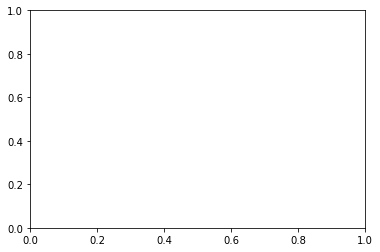

In [277]:

fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    #data=grid_vis,
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
    hue='kernel'
)

## run model svm with best params

In [256]:
def run_model_svm(X_train, y_train, X_test, y_test):
    scaler=MinMaxScaler()
    X_train_scaled= pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled= pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
    #model =SVC(kernel='linear',C=1000) # scoring = recall,  , accuracy, AUC ROC , refit ='auc roc' 
    #model=SVC(kernel='rbf',gamma=0.001,C=1)  # scoring = recall, precision , AUC_ROC , refit ='recall' df_svm1 [1], grid_tune1 = GridSearchCV(SVC(), param_grid=tuned_parameters, cv=cv, scoring= 'recall',verbose=4,refit='roc_auc')
    #model= SVC(kernel='poly',C=0.1,gamma=0.1) # when param grid was used 50 combination enede up , no degree was provided
    
   
    model.fit(X_train_scaled,y_train)


    #For TEST SPLIT
    y_pred= model.predict(X_test_scaled)
    cf_matrix = confusion_matrix(y_test, y_pred)
    accuracy= accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred) ##
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = cf_matrix[1][1] / ( cf_matrix[1][1] + cf_matrix[1][0] )
    auc = roc_auc_score(y_test, y_pred)
    type_1_error_FP = cf_matrix[0][1]
    type_2_error_FN = cf_matrix[1][0]
    log_loss_ = log_loss(y_test, y_pred)
    cohen_kappa_score_ = cohen_kappa_score(y_test, y_pred)
    #Note by default 1 is the positive label. Therefore, -1 is negative
    #bad waffe -> 2 line of matrix -> POSITIVE -> data = -1

    #For TRAIN SPLIT
    y_pred_train= model.predict(X_train)
    cf_matrix_train = confusion_matrix(y_train, y_pred_train)
    accuracy_train= accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train) ##
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    specificity_train = cf_matrix_train[1][1] / ( cf_matrix_train[1][1] + cf_matrix_train[1][0] )
    auc_train = roc_auc_score(y_train, y_pred_train)
    type_1_error_FP_train = cf_matrix_train[0][1]
    type_2_error_FN_train = cf_matrix_train[1][0]




    return cf_matrix, accuracy, f1, precision, recall, specificity, type_1_error_FP, type_2_error_FN, auc,log_loss_,cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, specificity_train, type_1_error_FP_train, type_2_error_FN_train, auc_train


In [257]:
cf_matrix, accuracy, f1, precision, recall, sensitivity, type_1_error_FP, type_2_error_FN, auc, log_loss_,cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, sensitivity_train, type_1_error_FP_train, type_2_error_FN_train, auc_train = run_model_svm(X_train_temp, y_train_temp, X_test_temp, y_test_temp)
svm_result.append((cf_matrix, accuracy, f1, precision, recall, sensitivity, type_1_error_FP, type_2_error_FN, auc, log_loss_, cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, sensitivity_train, type_1_error_FP_train, type_2_error_FN_train, auc_train))

In [258]:
# 1. default parameters svm
#df_svm_def = pd.DataFrame(result, columns = ['cf_matrix', 'accuracy', 'f1', 'precision', 'recall', 'sensitivity', 'type_1_error_FP', 'type_2_error_FN', 'auc', 'log_loss_','cohen_kappa_score_','cf_matrix_train', 'accuracy_train', 'f1_train', 'precision_train', 'recall_train', 'sensitivity_train', 'type_1_error_FP_train', 'type_2_error_FN_train', 'auc_train'])
# 2. default svm and C=100
# 3. default svm and C=10000
# 4. default svm and C=7000
# 5. default svm and C=1000, 
# 
#df_svm = pd.DataFrame(result, columns = ['cf_matrix', 'accuracy', 'f1', 'precision', 'recall', 'sensitivity', 'type_1_error_FP', 'type_2_error_FN', 'auc', 'log_loss_','cohen_kappa_score_','cf_matrix_train', 'accuracy_train', 'f1_train', 'precision_train', 'recall_train', 'sensitivity_train', 'type_1_error_FP_train', 'type_2_error_FN_train', 'auc_train'])
df_svm1 = pd.DataFrame(svm_result, columns = ['cf_matrix', 'accuracy', 'f1', 'precision', 'recall', 'sensitivity', 'type_1_error_FP', 'type_2_error_FN', 'auc', 'log_loss_','cohen_kappa_score_','cf_matrix_train', 'accuracy_train', 'f1_train', 'precision_train', 'recall_train', 'sensitivity_train', 'type_1_error_FP_train', 'type_2_error_FN_train', 'auc_train'])
df_svm1

,cf_matrix,accuracy,f1,precision,recall,sensitivity,type_1_error_FP,type_2_error_FN,auc,log_loss_,cohen_kappa_score_,cf_matrix_train,accuracy_train,f1_train,precision_train,recall_train,sensitivity_train,type_1_error_FP_train,type_2_error_FN_train,auc_train
0,"[[72, 221], [1, 20]]",0.292994,0.152672,0.082988,0.952381,0.952381,221,1,0.599057,24.419698,0.033793,"[[755, 0], [1018, 0]]",0.425832,0.000000,0.000000,0.0,0.0,0,1018,0.5
1,"[[0, 293], [0, 21]]",0.066879,0.125373,0.066879,1.000000,1.000000,293,0,0.500000,32.229604,0.000000,"[[0, 755], [0, 1018]]",0.574168,0.729488,0.574168,1.0,1.0,755,0,0.5
2,"[[0, 293], [0, 21]]",0.066879,0.125373,0.066879,1.000000,1.000000,293,0,0.500000,32.229604,0.000000,"[[755, 0], [1018, 0]]",0.425832,0.000000,0.000000,0.0,0.0,0,1018,0.5


# Appendix

# PART 2: EXECUTION

In [21]:
fast_track_cols = X_test.columns
fast_track_cols.shape

(466,)

In [18]:
X = read_features()
y = read_target().iloc[:,0]

removing_coli = 'No'
#['Yes', 'No']

result = []
i = 1



#step 1:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify=y)
#change random state??

#-----------

# # step 2:
X_train = remove_duplicated_columns(X_train)
# #step 3:
X_train = remove_constant_volatility(X_train)
# #step 4:
X_train = remove_cols_with_high_pct_null(X_train, 0.8) #this can be in the loop too, may be later
# #step 5: remove the same columns from step 2-4 TRAIN_TEST split
X_test = X_test.loc[:,X_train.columns]

#------------
fast_track_cols = X_test.columns

X_train = X_train.loc[:, fast_track_cols]
X_test = X_test.loc[:, fast_track_cols]

#------------




#step 6-9
replace_outlier_options = ['3s'] #nothing at all
#replace_outlier_options = ['3s','NaN','nothing']
impute_null_options = ['knn__distance']
#impute_null_options = ['knn__distance', 'MICE', 'knn__uniform']
FS_options = ['BoS__shap']
#FS_options = ['BoP','BoS__shap', 'BoS__gini', 'RFE__RF', 'RFE__SVM', 'nothing]
sampling_options = ['SMOTEENN'] #TRY OTHER SAMPLING
#sampling_options = ['SMOTE','ROSE','ADASYN','SMOTEENN']
model_options = ['RF']
#model_options = ['LR', 'RF', 'NN']
#try RF=10depth

#next: TRY KNN DISTANCE

for replace_with in replace_outlier_options:
    for knn_weight in impute_null_options:
        for classifier_model in FS_options:
            for sampling_technique in sampling_options:
                for Model in model_options:
                    X_train_temp = X_train
                    X_test_temp = X_test
                    y_train_temp = y_train
                    y_test_temp = y_test

                    combined_technique = replace_with +' & '+ knn_weight +' & '+ classifier_model + ' & ' + removing_coli +' & '+ sampling_technique +' & '+ Model

                    #step 6: oulier treatement (on both TRAIN & TEST split)
                    if replace_with != 'nothing':
                        X_train_temp = replace_outlier(X_train_temp, replace_with)
                        X_test_temp = replace_outlier(X_test_temp, replace_with)
                    
                    #step 7: missing value imputation (on both TRAIN & TEST split)
                    if knn_weight == 'knn__distance' or knn_weight == 'knn__uniform':
                        X_train_temp, X_test_temp = impute_null_with_knn(X_train_temp, X_test_temp, knn_weight[-(len(knn_weight)-5):])
                    elif knn_weight == 'MICE':
                        X_train_temp, X_test_temp = impute_null_with_mice(X_train_temp, X_test_temp)

                    #step 8: feature selection (on both TRAIN & TEST split)
                    if classifier_model !='nothing':
                        if classifier_model == 'BoS__shap' or classifier_model == 'BoS__gini':
                            X_train_temp = BorutaShap_FS(X_train_temp, y_train_temp, classifier_model[-(len(classifier_model)-5):])
                        elif classifier_model == 'RFE__RF' or classifier_model == 'RFE__SVM':
                            X_train_temp = RFE_FS(X_train_temp, y_train_temp, classifier_model[-(len(classifier_model)-5):])
                        elif classifier_model == 'BoP':
                            X_train_temp = BorutaPy_FS(X_train_temp, y_train_temp)
                    

                        #step 9: remove multilinear features
                    if removing_coli=='Yes':
                        print('n_cols BEFORE multicolinearity treatement', X_train_temp.shape[1])
                        X_train_temp = remove_collinear_features(X_train_temp, 0.7)
                        print('n_cols AFTER multicolinearity treatement', X_train_temp.shape[1])

                    #apply the same result for TEST
                    X_test_temp = X_test_temp.loc[:,X_train_temp.columns]

                    #print out datasets for backup
                    #X_train_temp.to_csv('sampling_visualization/X_train_temp_BEFORESAMPLING_'+str(i)+combined_technique+'.csv')
                    #X_test_temp.to_csv('sampling_visualization/X_test_temp_BEFORESAMPLING_'+str(i)+combined_technique+'.csv')
                    #y_train_temp.to_csv('sampling_visualization/y_train_temp_BEFORESAMPLING_'+str(i)+combined_technique+'.csv')
                    #y_test_temp.to_csv('sampling_visualization/y_test_temp_BEFORESAMPLING_'+str(i)+combined_technique+'.csv')

                    #step 10: balancing only on TRAIN split
                    X_train_temp, y_train_temp = sampling(X_train_temp, y_train_temp, sampling_technique)

                    #print out datasets for backup
                    #X_train_temp.to_csv('sampling_visualization/X_train_temp_AFTERSAMPLING_'+str(i)+combined_technique+'.csv')
                    #X_test_temp.to_csv('sampling_visualization/X_test_temp_AFTERSAMPLING_'+str(i)+combined_technique+'.csv')
                    #y_train_temp.to_csv('sampling_visualization/y_train_temp_AFTERSAMPLING_'+str(i)+combined_technique+'.csv')
                    #y_test_temp.to_csv('sampling_visualization/y_test_temp_AFTERSAMPLING_'+str(i)+combined_technique+'.csv')


                    #step 11: train model, predict, and print scores
                    if Model != 'NN':
                        try:
                            cf_matrix, accuracy, f1, precision, recall, sensitivity, type_1_error_FP, type_2_error_FN, auc, log_loss_,cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, sensitivity_train, type_1_error_FP_train, type_2_error_FN_train, auc_train = run_model(X_train_temp, y_train_temp, X_test_temp, y_test_temp, Model)
                        except Exception:
                            cf_matrix = accuracy = f1 = precision = recall = sensitivity = type_1_error_FP = type_2_error_FN = auc = log_loss_ =cohen_kappa_score_ = cf_matrix_train = accuracy_train = f1_train = precision_train = recall_train = sensitivity_train = type_1_error_FP_train = type_2_error_FN_train = auc_train = 0
                    #elif Model == 'NN':
                    #    try:
                    #        cf_matrix, accuracy, f1, precision, recall, sensitivity, type_1_error_FP, type_2_error_FN, auc, log_loss_,cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, sensitivity_train, type_1_error_FP_train, type_2_error_FN_train, auc_train = run_model_NN(X_train_temp, y_train_temp, X_test_temp, y_test_temp)
                    #    except Exception:
                    #        cf_matrix = accuracy = f1 = precision = recall = sensitivity = type_1_error_FP = type_2_error_FN = auc = log_loss_ =cohen_kappa_score_ = cf_matrix_train = accuracy_train = f1_train = precision_train = recall_train = sensitivity_train = type_1_error_FP_train = type_2_error_FN_train = auc_train = 0

                    result.append((i, combined_technique, X_train_temp.shape[1], replace_with, knn_weight, classifier_model, removing_coli, sampling_technique, Model, X_train_temp.columns, cf_matrix, accuracy, f1, precision, recall, sensitivity, type_1_error_FP, type_2_error_FN, auc, log_loss_, cohen_kappa_score_, cf_matrix_train, accuracy_train, f1_train, precision_train, recall_train, sensitivity_train, type_1_error_FP_train, type_2_error_FN_train, auc_train))
                    
                    print('attemp no.: ',i, combined_technique,' acc: ', accuracy,' accuracy_train: ',accuracy_train, ' f1: ', f1,' f1_train: ',f1_train, ' sensitivity: ', sensitivity, ' :auc ', auc, ' cfm: ', '\n', cf_matrix, '\n n_cols', X_train_temp.shape[1])
                    

                    if i%5==0: 
                        df_result = pd.DataFrame(result, columns = ['No.','combination','n_cols','outlier_replace_with', 'imputation_knn_weight', 'FS_classifier_model', 'removing_coli','balancing_sampling_technique', 'Model','cols','cf_matrix', 'accuracy', 'f1', 'precision', 'recall', 'sensitivity', 'type_1_error_FP', 'type_2_error_FN', 'auc', 'log_loss_','cohen_kappa_score_','cf_matrix_train', 'accuracy_train', 'f1_train', 'precision_train', 'recall_train', 'sensitivity_train', 'type_1_error_FP_train', 'type_2_error_FN_train', 'auc_train'])
                        #df_result.to_csv('tracker/result'+str(i)+'.csv')
                    

                    i+=1



df_result = pd.DataFrame(result, columns = ['No.','combination','n_cols','outlier_replace_with', 'imputation_knn_weight', 'FS_classifier_model', 'removing_coli','balancing_sampling_technique', 'Model','cols','cf_matrix', 'accuracy', 'f1', 'precision', 'recall', 'sensitivity', 'type_1_error_FP', 'type_2_error_FN', 'auc', 'log_loss_','cohen_kappa_score_','cf_matrix_train', 'accuracy_train', 'f1_train', 'precision_train', 'recall_train', 'sensitivity_train', 'type_1_error_FP_train', 'type_2_error_FN_train', 'auc_train'])
#df_result.to_csv('tracker/bm.csv')



100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


attemp no.:  1 3s & knn__distance & BoS__shap & No & SMOTEENN & RF  acc:  0.7197452229299363  accuracy_train:  0.9142695995487874  f1:  0.25423728813559326  f1_train:  0.9285042333019755  sensitivity:  0.7142857142857143  :auc  0.7172111165285228  cfm:  
 [[211  82]
 [  6  15]] 
 n_cols 19


In [23]:
df_3pt= df_result.loc[:,['cf_matrix', 'accuracy', 'f1', 'precision', 'recall', 'sensitivity', 'type_1_error_FP', 'type_2_error_FN', 'auc','cf_matrix_train', 'accuracy_train', 'f1_train', 'precision_train', 'recall_train', 'sensitivity_train', 'type_1_error_FP_train', 'type_2_error_FN_train', 'auc_train']]

In [24]:
df_3pt

,cf_matrix,accuracy,f1,precision,recall,sensitivity,type_1_error_FP,type_2_error_FN,auc,cf_matrix_train,accuracy_train,f1_train,precision_train,recall_train,sensitivity_train,type_1_error_FP_train,type_2_error_FN_train,auc_train
0,"[[211, 82], [6, 15]]",0.719745,0.254237,0.154639,0.714286,0.714286,6,82,0.717211,"[[634, 121], [31, 987]]",0.91427,0.928504,0.890794,0.969548,0.969548,31,121,0.904642
